In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns

In [29]:
data = pd.read_csv('all_data_results.csv')

In [30]:
data.dtypes

pipe_dn                     int64
pipe_schedule              object
flange_class                int64
outside_diameter          float64
length1                   float64
length2                   float64
wall_thickness            float64
lumped_mass               float64
raised_face_depth         float64
w_neck_c                  float64
flange_outer_radius       float64
flange_thickness_d        float64
raised_face_radius        float64
hot_spot_stress           float64
frequency                 float64
max_deformation           float64
x_deformation_position    float64
y_deformation_position    float64
z_deformation_position    float64
support_right              object
support_left               object
support                    object
ratio                     float64
allowable_deformation     float64
dtype: object

In [48]:
numeric_features = ['pipe_dn', 'flange_class', 'outside_diameter', 'length1', 'length2', 'wall_thickness', 'lumped_mass',
                    'raised_face_depth', 'w_neck_c', 'flange_outer_radius', 'flange_thickness_d', 'raised_face_radius', 'hot_spot_stress',
                    'max_deformation', 'ratio']
categorical_features = ['pipe_schedule', 'support_right','support_left', 'support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [49]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [87]:
target_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(target_columns, axis=1)
y = data[target_columns]

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [62]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [63]:
scaler_y = StandardScaler()
y_train_transformed = scaler_y.fit_transform(y_train)
y_test_transformed = scaler_y.transform(y_test)

In [64]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(64, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)
hidden3 = Dense(16, activation='relu')(dropout2)

# Separate output for each target variable
output_allowable_deformation = Dense(1, name='allowable_deformation')(hidden3)
output_frequency = Dense(1, name='frequency')(hidden3)
output_x_position = Dense(1, name='x_deformation_position')(hidden3)
output_y_position = Dense(1, name='y_deformation_position')(hidden3)
output_z_position = Dense(1, name='z_deformation_position')(hidden3)

In [131]:
model = Model(inputs=input_layer, outputs=[output_allowable_deformation, output_frequency, 
                                           output_x_position, output_y_position, output_z_position])

In [132]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=['mse', 'mse', 'mse', 'mse', 'mse'],
              loss_weights=[1.0, 1.0, 1.0, 1.0, 1.0])

In [133]:
history = model.fit(
    x_train_transformed, 
    [y_train_transformed[:, i] for i in range(5)],  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=1000,
    batch_size=64,
    verbose=1
)

Epoch 1/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - allowable_deformation_loss: 0.0653 - frequency_loss: 0.0968 - loss: 1.1104 - x_deformation_position_loss: 0.0634 - y_deformation_position_loss: 0.4060 - z_deformation_position_loss: 0.4788 - val_allowable_deformation_loss: 0.0427 - val_frequency_loss: 0.0640 - val_loss: 0.9744 - val_x_deformation_position_loss: 0.0525 - val_y_deformation_position_loss: 0.3199 - val_z_deformation_position_loss: 0.4941
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - allowable_deformation_loss: 0.0830 - frequency_loss: 0.0898 - loss: 1.1386 - x_deformation_position_loss: 0.0698 - y_deformation_position_loss: 0.4014 - z_deformation_position_loss: 0.4947 - val_allowable_deformation_loss: 0.0448 - val_frequency_loss: 0.0569 - val_loss: 0.9802 - val_x_deformation_position_loss: 0.0578 - val_y_deformation_position_loss: 0.3226 - val_z_deformation_position_loss: 0.4968
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - allowable_deformation_

In [70]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      1,920 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 16)        │        528 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ allowable_deformat… │ (None, 1)         │         17 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frequency (Dense)   │ (None, 1)         │         17 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_deformation_posi… │ (None, 1)         │         17 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y_deformation_posi… │ (None, 1)         │         17 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_deformation_posi… │ (None, 1)         │         17 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,841 (54.07 KB)

 Trainable params: 4,613 (18.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,228 (36.05 KB)

In [99]:
def split_outputs(x):
    return [x[:, i:i+1] for i in range(5)]

# Build the model
model2 = Sequential([
    Input(shape=(x_train_transformed.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(5),  # Output 5 values
    Lambda(split_outputs)  # Split into 5 separate outputs
])

In [100]:
model2.compile(optimizer=Adam(learning_rate=0.001), 
              loss=['mse', 'mse', 'mse', 'mse', 'mse'],
              loss_weights=[1.0, 1.0, 1.0, 1.0, 1.0])  # Adjust weights if needed

In [101]:
history2 = model2.fit(
    x_train_transformed, 
    [y_train_transformed[:, i] for i in range(5)],  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.0272 - mse_loss: 1.0206 - val_loss: 2.3790 - val_mse_loss: 0.8285
Epoch 2/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.7557 - mse_loss: 0.8486 - val_loss: 1.8553 - val_mse_loss: 0.8046
Epoch 3/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4019 - mse_loss: 0.8439 - val_loss: 1.6710 - val_mse_loss: 0.7737
Epoch 4/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1730 - mse_loss: 0.8555 - val_loss: 1.6086 - val_mse_loss: 0.7604
Epoch 5/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0123 - mse_loss: 0.7936 - val_loss: 1.5140 - val_mse_loss: 0.7448
Epoch 6/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9618 - mse_loss: 0.7748 - val_loss: 1.4624 - val_mse_loss: 0.7220
Epoch 7/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.8459 - mse_loss: 0.7473 - val_loss: 1.4301 - val_mse_loss: 0.7107
Epoch 8/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8986 - mse_loss: 0.7692 - val_loss

In [109]:
test_loss = model.evaluate(x_test_transformed, [y_test_transformed[:, i] for i in range(5)], verbose=0)
print("\nTest Loss:")
for i, name in enumerate(target_columns):
    print(f"{name} MSE: {test_loss[i+1]:.4f}")


Test Loss:
allowable_deformation MSE: 0.1248
frequency MSE: 0.1223
x_deformation_position MSE: 0.0734
y_deformation_position MSE: 0.3430
z_deformation_position MSE: 0.4678


In [134]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y.inverse_transform(np.column_stack(predictions_scaled))

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [135]:
predictions_df = pd.DataFrame(predictions, columns=target_columns)
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
   allowable_deformation  frequency  x_deformation_position  \
0              39.238033   4.341345            -3132.066162   
1               6.647359  13.143929             -145.211609   
2              28.258476  13.204520            -2014.598755   
3              23.869524   5.165351             -371.849091   
4               9.793065   8.016560             -385.282715   

   y_deformation_position  z_deformation_position  
0               42.323303                1.325905  
1               -4.335889             -166.701889  
2              194.569824               -6.321375  
3                9.972421               18.410936  
4                4.893502               89.007774  


[]

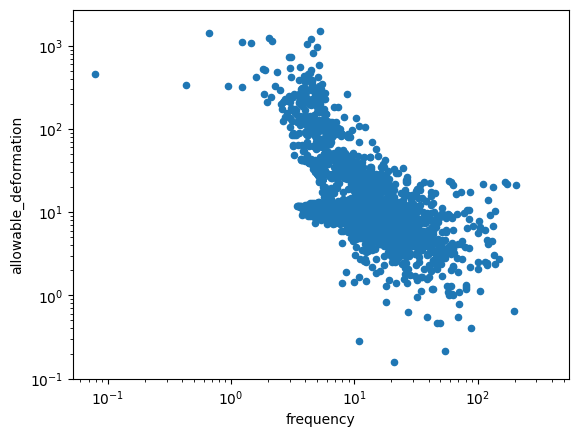

In [136]:
predictions_df.plot(x="frequency",y="allowable_deformation",kind="scatter")
plt.loglog()

In [1]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

NameError: name 'plt' is not defined

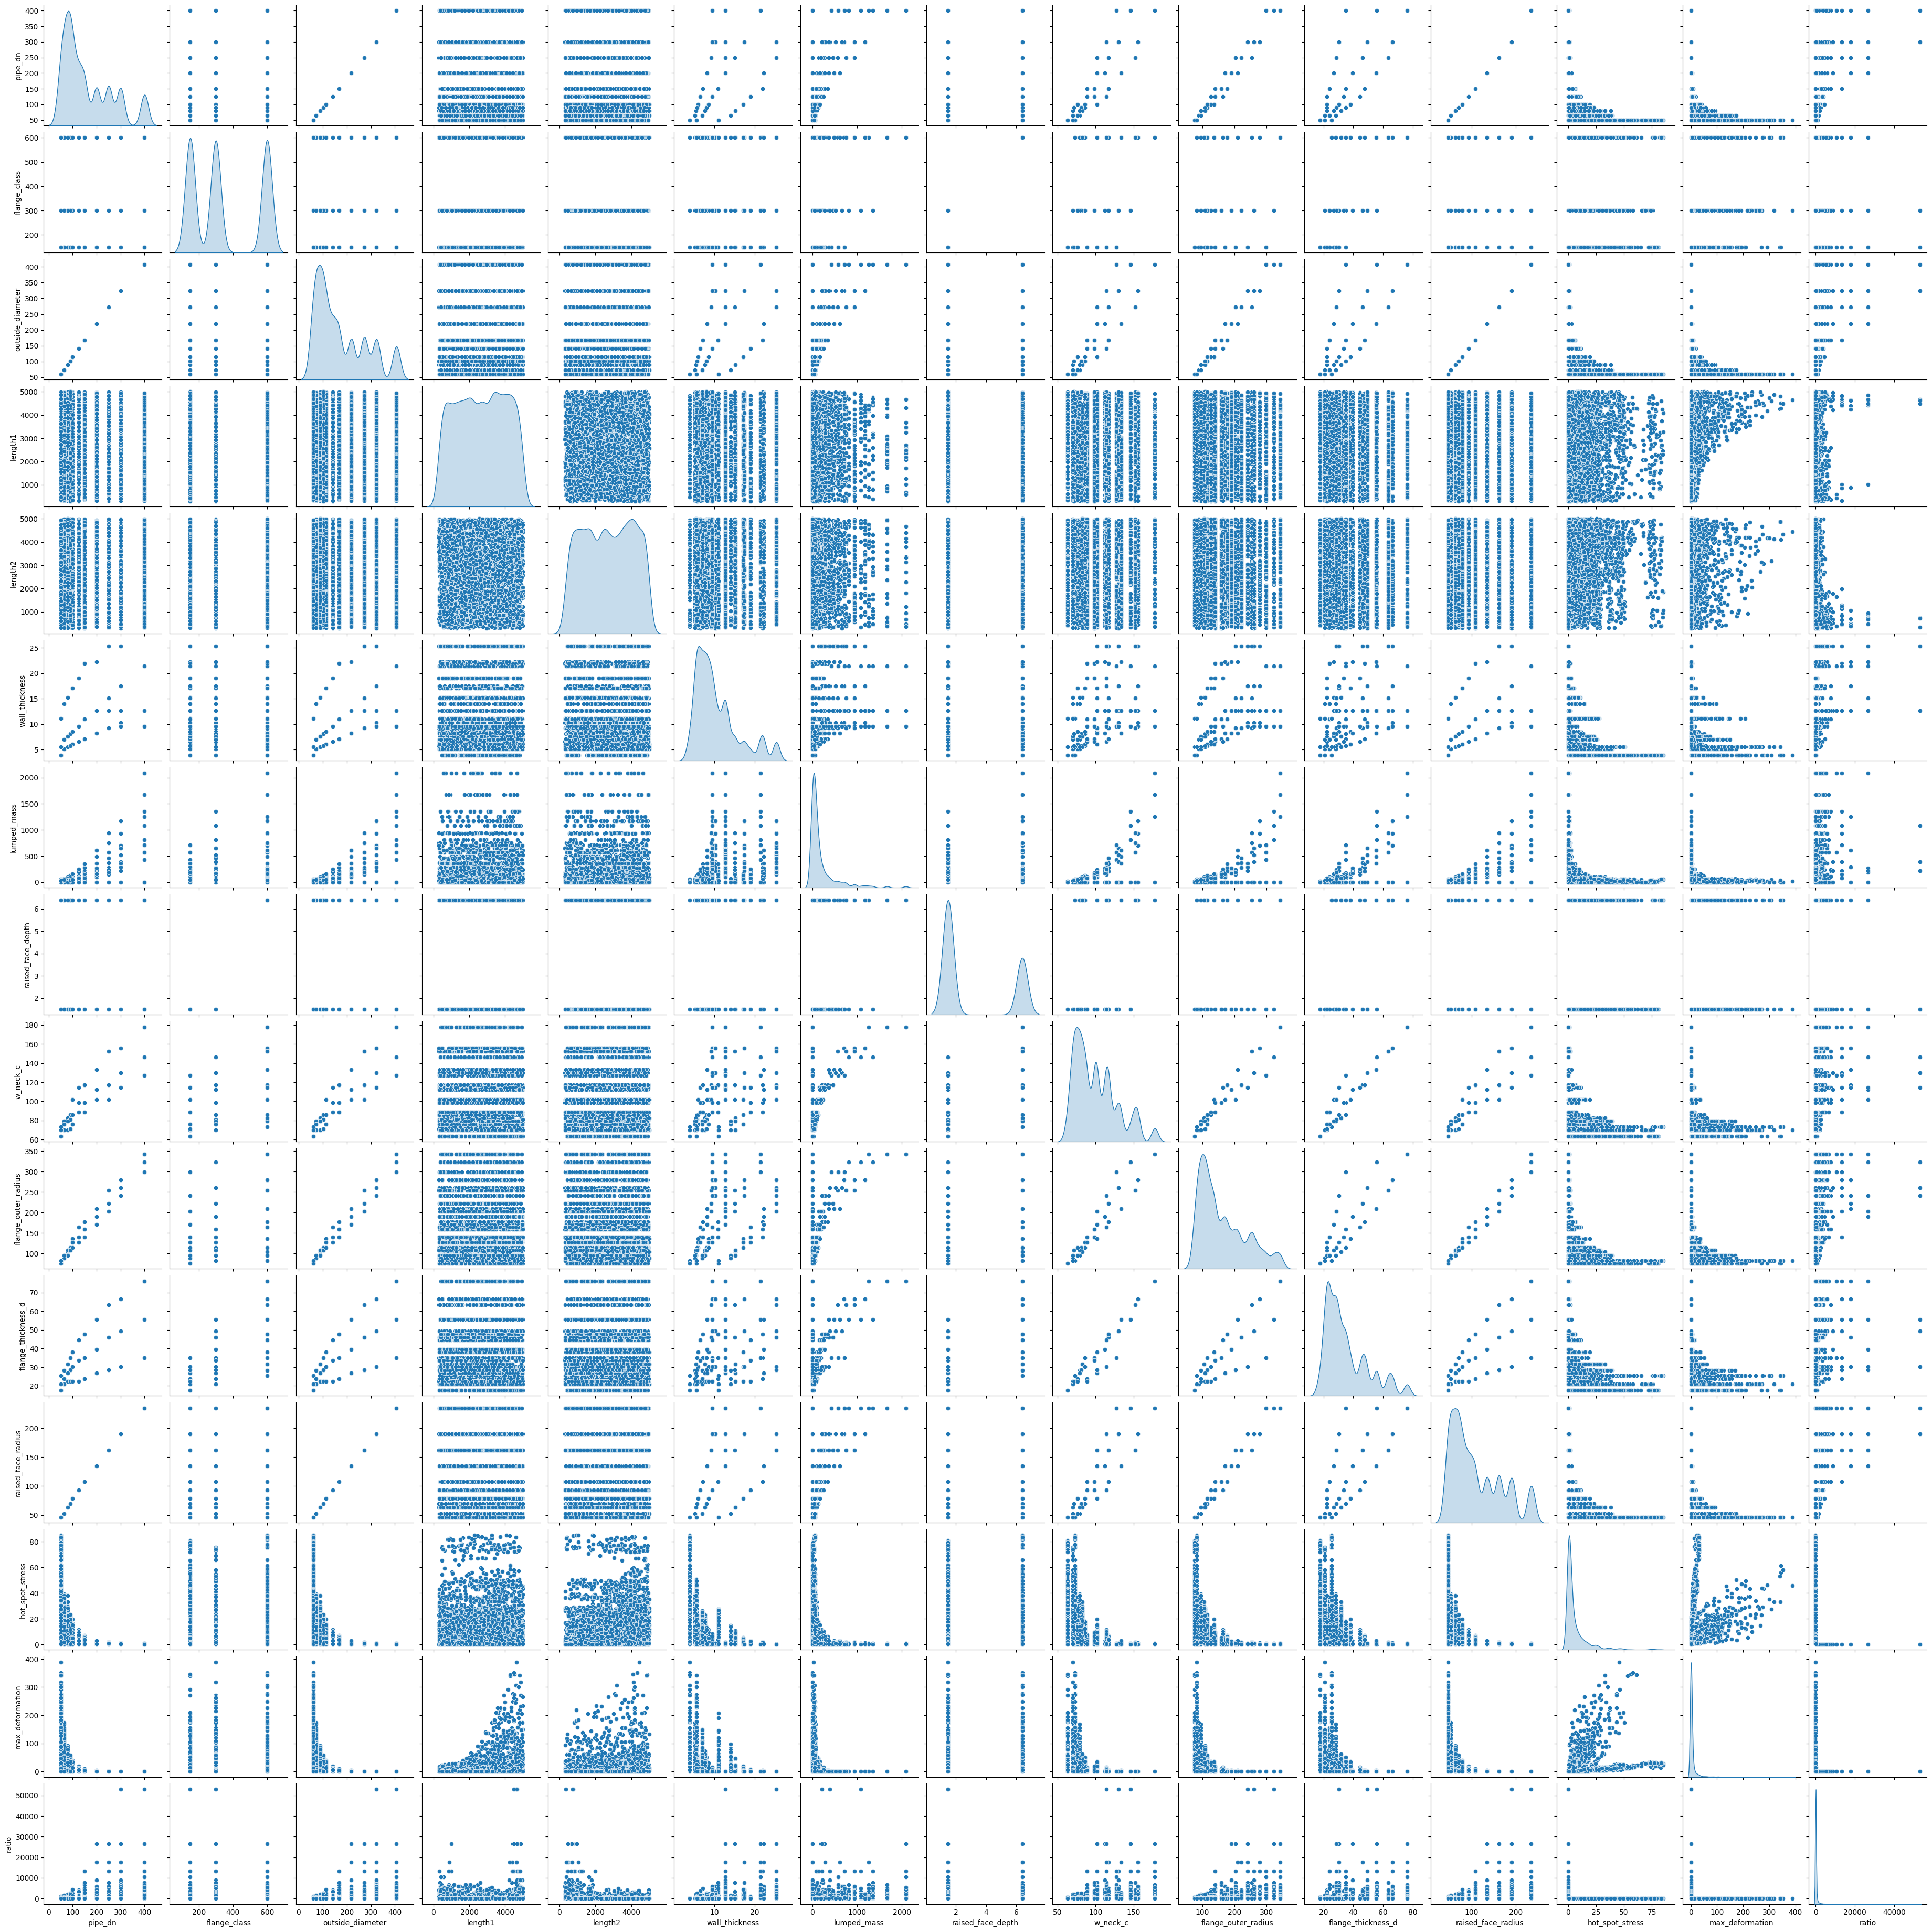

In [ ]:
sns.pairplot(x_train,diag_kind='kde')